<a href="https://colab.research.google.com/github/marcinwolter/MedicalPictures/blob/master/Fig_CNN_Qual_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Distort image and find the visual qualities

from scipy import ndimage
#PILlow package
from PIL import Image
from io import BytesIO
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt

img_shape = (32, 32)

# distortion type
###distortion = "blur"
distortion = "jpeg"
# jpeg_format: jpeg / JPEG2000   - WARNING:  JPEG 2000 does not work on Kaggle!!!!
jpeg_format = "jpeg"
#jpeg_format = 'JPEG2000'
#jpeg_format="jpx"
# distortion - bluring sigma
sigma = (1.8,1.8)



# extrapolate True/False
extrapolate = True
# list of extrapolation factors
extrapolation_list = [0.50, 1., 2.]
###extrapolation_list = [1.]

In [36]:
# Distort images


from skimage.metrics import mean_squared_error, structural_similarity, normalized_root_mse



def calc_ssim_mse(images, distorted_images):
# Calculate SSIM & MSE using https://scikit-image.org/docs/dev/genindex.html  

   mse = 0  # mean_squared_error
   nrmse = 0 # normalized_root_mse
   sim = 0   # structural_similarity

   for n in range(len(images)): 
      im_array = np.asarray(images[n]).reshape(img_shape)
      imtest_array = np.asarray(distorted_images[n]).reshape(img_shape)
      
      #print("im shape ",im_array.shape)
      mse += mean_squared_error(im_array, imtest_array)
      nrmse += normalized_root_mse(im_array, imtest_array, normalization='euclidean')
      sim +=  structural_similarity(im_array, imtest_array, win_size=7, full=False)

# PLEASE put here the Qual_ind calculation!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!      

   return mse/len(images), nrmse/len(images), sim/len(images)


def distort_n_figures(images, jpeg_compression, distortion=distortion, img_shape=img_shape, sigma = sigma):
  
  if (distortion == "blur"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    for n in range(len(images)):
     
    
      images_distorted[n,0] = ndimage.gaussian_filter(255.*images[n,0], sigma=sigma)/255.
#      images_distorted[n,0] = images[n,0]

    mse, nrmse, ssim = calc_ssim_mse(images, images_distorted)
    return -1, mse, nrmse, ssim, images_distorted

  elif (distortion == "jpeg"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
 
    #n_big = len(images)

    for n in range(len(images)):
        # convert to jpeg and than back
        if  (n+1)%10000==0:
           print("Distorting image ",n)

        buffer = BytesIO()
        auxIm = Image.fromarray((255.*images[n,0]).astype(np.uint8))

 
        if jpeg_format == 'jpeg':
           auxIm.save(buffer, format=jpeg_format, quality=jpeg_compression)

        elif jpeg_format == 'JPEG2000':
           auxIm.save(buffer, format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True) 
    
        else:
           print("Unknown format %s" % jpeg_format)    


  
        buffer.seek(0)
        auxIm = Image.open(buffer)

        # resize image and then resize back to the original size using BICUBIC/NEAREST/BILINEAR
        if (extrapolation_factor != 1.):
           width, height = auxIm.size
           auxIm = auxIm.resize((int(extrapolation_factor*width),int(extrapolation_factor*height)),resample=method)
           #print("image size ",auxIm.size)
           auxIm = auxIm.resize((width,height),resample=method)
        

        # add image to the array of distorted images
        images_distorted[n,0] = np.array(auxIm) / 255.  
 

    
    mse, nrmse, ssim = calc_ssim_mse(images, images_distorted)
    return  mse, nrmse, ssim, images_distorted

  else:
    return -1, -1, -1, -1, images  

--2020-07-13 21:28:31--  https://github.com/marcinwolter/MedicalPictures/raw/master/images.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcinwolter/MedicalPictures/master/images.zip [following]
--2020-07-13 21:28:31--  https://raw.githubusercontent.com/marcinwolter/MedicalPictures/master/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135851 (133K) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>] 132.67K  --.-KB/s    in 0.04s   

2020-07-13 21:28:31 (3.30 MB/s) - ‘images.zip’ saved [135851/135851]

Archive:  images.zip
  inflating: image_0.b

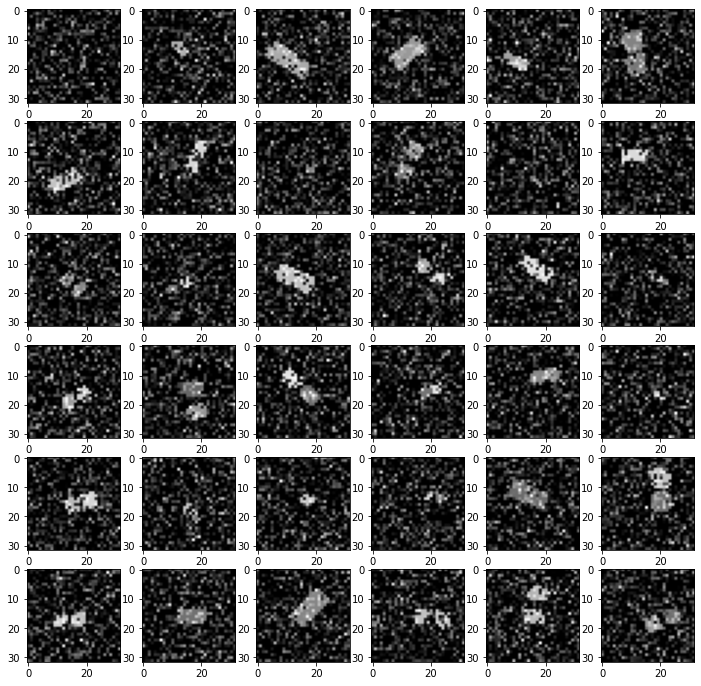

In [37]:

n_images = 100
# empty images
xx_images  = np.zeros((n_images, 1, img_shape[0], img_shape[1]))
# unzip images
! rm -f image_*.bmp
! rm -f images.zip
! wget https://github.com/marcinwolter/MedicalPictures/raw/master/images.zip
! unzip images.zip

# read images from bmp files
plot_size = 6
plt.figure(figsize = (12,12))
for k in range(n_images):
  xx_images[k,0] = np.array(Image.open("image_"+str(k)+".bmp")) / 255.
  if k < plot_size*plot_size:
    ax = plt.subplot(plot_size, plot_size, k+1)
    ax.imshow(xx_images[k,0], cmap='gray', vmin=0, vmax=1)    
plt.show()  

In [38]:
# Distort images

# jpeg quality
jpeg_compression = 10
# to extrapolate/contract an image
extrapolation_factor = 2.0
#resample method BICUBIC/NEAREST/BILINEAR
#method = Image.BICUBIC
method = Image.BILINEAR
#method = Image.NEAREST

mse, nrmse, ssim, xx_distorted = distort_n_figures(xx_images, jpeg_compression)
print("Average values of visual quality parameters:")
print("mse = ", mse)
print("nrmse = ",nrmse)
print("ssim = ", ssim)



Average values of visual quality parameters:
mse =  0.02444790269968282
nrmse =  0.6324048476622721
ssim =  0.4665392256160984


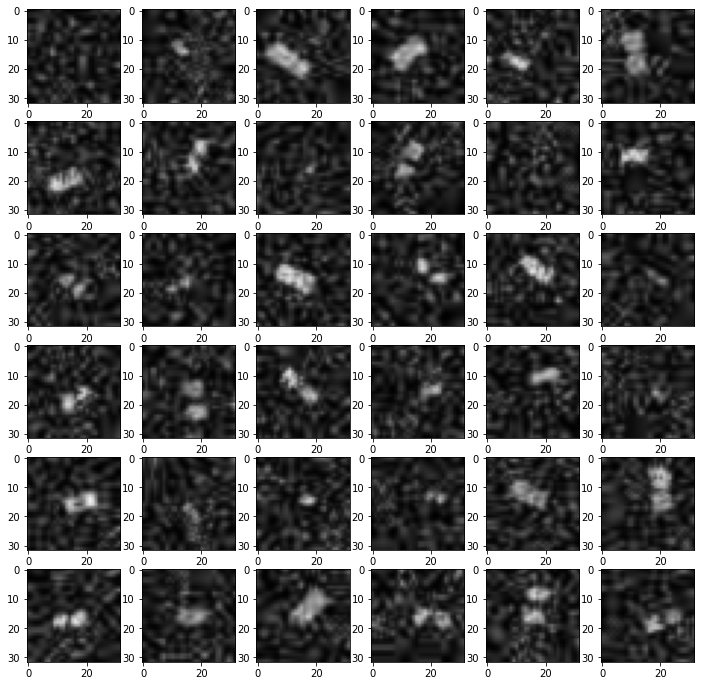

In [39]:
# draw distorted images
plot_size = 6
plt.figure(figsize = (12,12))
for k in range(n_images):
  if k < plot_size*plot_size:
    ax = plt.subplot(plot_size, plot_size, k+1)
    ax.imshow(xx_distorted[k,0], cmap='gray', vmin=0, vmax=1)    
plt.show()  